In this tutorial, we’ll explore how the structural design of decision trees can sometimes work against them. Using a simple synthetic dataset, we’ll see how decision trees struggle with diagonal decision boundaries, inspect the split criteria they learn, and use PCA as a diagnostic tool to understand when a different model—or better feature engineering—might be the smarter choice.

In [23]:
!pip install matplotlib scikit-learn numpy seaborn

# Creating the Dataset
In this code, we generate a synthetic 2D dataset with a diagonal decision boundary defined by the condition
𝑥1 + 𝑥2 > 0

The points are colored by class, and the dashed line represents the true underlying boundary separating the two classes. This setup creates a dataset that is simple to separate but intentionally misaligned with the axis-aligned splits used by decision trees.

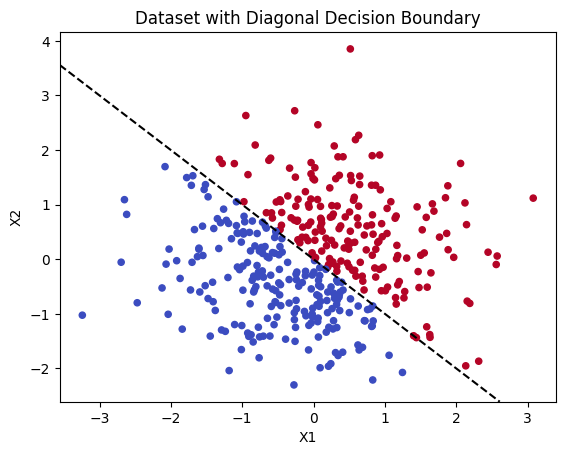

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Generate points
n = 400
X = np.random.randn(n, 2)

# Diagonal decision boundary: x1 + x2 > 0
y = (X[:, 0] + X[:, 1] > 0).astype(int)

# Plot
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=20)
plt.axline((0, 0), slope=-1, color="black", linestyle="--")
plt.title("Dataset with Diagonal Decision Boundary")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

# Fitting a Decision Tree on the Original Features

In [2]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=10, random_state=42)
tree.fit(X, y)

DecisionTreeClassifier(max_depth=10, random_state=42)

# Visualizing the Decision Boundary Learned by the Tree
Here, we visualize the decision boundary learned by the decision tree in the original feature space. A dense mesh grid is created over the input space, and the model’s predictions are computed for each point to form the contour plot. The resulting boundary shows how the decision tree approximates the diagonal separation using many axis-aligned splits.

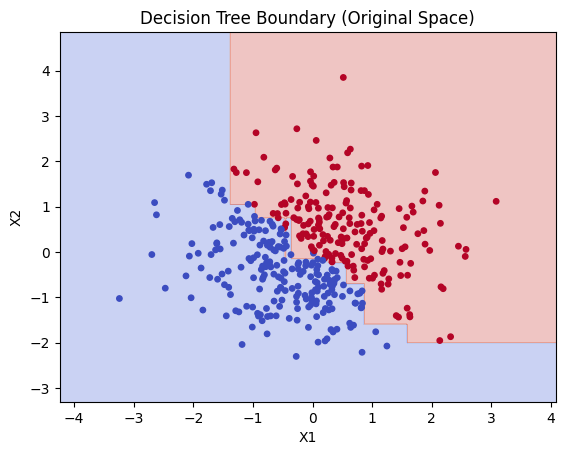

In [3]:
# Create mesh grid
xx, yy = np.meshgrid(
    np.linspace(X[:,0].min()-1, X[:,0].max()+1, 300),
    np.linspace(X[:,1].min()-1, X[:,1].max()+1, 300)
)

Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
plt.scatter(X[:,0], X[:,1], c=y, cmap="coolwarm", s=15)
plt.title("Decision Tree Boundary (Original Space)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

# Inspecting Tree Depth and Structure
We use get_depth() and get_n_leaves() to inspect the structural complexity of the trained decision tree and quantify how many splits it needed to fit the data.

The output shows that the decision tree has a depth of 6 and 19 leaf nodes. For a dataset with a simple, linear diagonal boundary, this level of depth and number of leaves is unnecessarily high, indicating that the tree is adding complexity to approximate a structure it is not naturally suited to model.

In [4]:
tree.get_depth(), tree.get_n_leaves()

(6, np.int64(19))

# Applying PCA (Same Dimensionality)
Here, we apply PCA to the dataset without reducing its dimensionality, effectively rotating the feature space. This transformation helps align the data with orthogonal axes, making it easier to diagnose whether the underlying decision boundary is diagonal.

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Visualizing Data in PCA Space
This plot shows the same data after projecting it into PCA space. The two classes are now separated almost along a single principal component, revealing that the original diagonal boundary has become nearly axis-aligned.



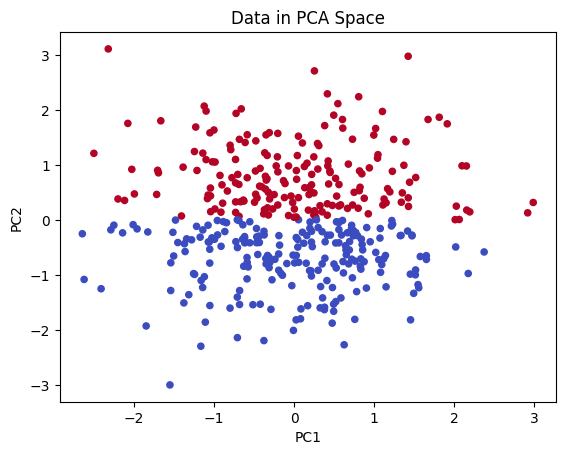

In [6]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="coolwarm", s=20)
plt.title("Data in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Fitting a Decision Tree on PCA-Projected Data
We now train a decision tree on the PCA-transformed data and visualize its decision boundary in the rotated feature space. Unlike the original space, the boundary here is much cleaner and nearly perpendicular to a principal component, allowing the tree to separate the classes with far fewer splits and significantly lower complexity.

In [7]:
tree_pca = DecisionTreeClassifier(max_depth=10, random_state=42)
tree_pca.fit(X_pca, y)

DecisionTreeClassifier(max_depth=10, random_state=42)

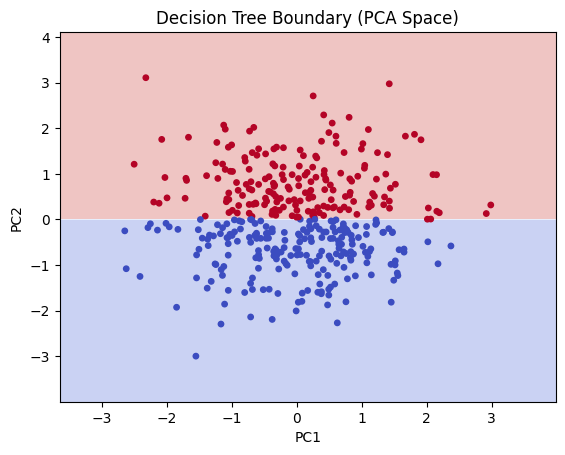

In [8]:
xx, yy = np.meshgrid(
    np.linspace(X_pca[:,0].min()-1, X_pca[:,0].max()+1, 300),
    np.linspace(X_pca[:,1].min()-1, X_pca[:,1].max()+1, 300)
)

Z = tree_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="coolwarm", s=15)
plt.title("Decision Tree Boundary (PCA Space)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Comparing Tree Complexity
This comparison clearly highlights the impact of feature alignment on decision trees. In the original feature space, the tree requires a depth of 6 and 19 leaves to approximate the diagonal boundary. After projecting the data into PCA space, the same task is solved with a depth of just 1 and 2 leaves, confirming that the original complexity was purely due to misalignment with the tree’s axis-aligned splitting mechanism.

In [9]:
print("Original space:")
print("Depth:", tree.get_depth(), "Leaves:", tree.get_n_leaves())

print("\nPCA space:")
print("Depth:", tree_pca.get_depth(), "Leaves:", tree_pca.get_n_leaves())

Original space:
Depth: 6 Leaves: 19

PCA space:
Depth: 1 Leaves: 2


# Extracting & Analyzing the Split Criteria from the initially trained Decision Tree
This analysis inspects the actual split criteria learned by the decision tree. By extracting every feature and threshold used in the tree, we can see how frequently and how finely the model splits each feature.

In [10]:
from sklearn.tree import _tree

def extract_splits(tree, feature_names=None):
    tree_ = tree.tree_
    splits = []

    for i in range(tree_.node_count):
        if tree_.feature[i] != _tree.TREE_UNDEFINED:
            feature = tree_.feature[i]
            threshold = tree_.threshold[i]
            splits.append((feature, threshold))

    return splits


In [20]:
splits = extract_splits(tree)

# Separate thresholds by feature
splits_x1 = [t for f, t in splits if f == 0]
splits_x2 = [t for f, t in splits if f == 1]

print(f"Number of splits on X1: {len(splits_x1)}")
print(f"Number of splits on X2: {len(splits_x2)}")

Number of splits on X1: 9
Number of splits on X2: 9


The histogram shows that the tree performs many splits on both X1 and X2, with thresholds densely packed across a narrow range.

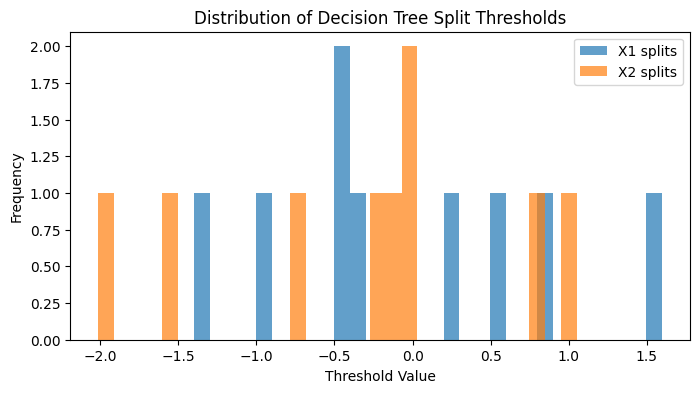

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(splits_x1, bins=30, alpha=0.7, label="X1 splits")
plt.hist(splits_x2, bins=30, alpha=0.7, label="X2 splits")
plt.title("Distribution of Decision Tree Split Thresholds")
plt.xlabel("Threshold Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [22]:
def min_threshold_gap(thresholds):
    thresholds = np.sort(thresholds)
    return np.min(np.diff(thresholds))

print("Minimum gap between X1 thresholds:", min_threshold_gap(splits_x1))
print("Minimum gap between X2 thresholds:", min_threshold_gap(splits_x2))

Minimum gap between X1 thresholds: 0.02307698130607605
Minimum gap between X2 thresholds: 0.021463905461132526


The small minimum gaps between consecutive thresholds (≈ 0.02 for both features) confirm that the tree is making very fine-grained, closely spaced splits. This is strong evidence that the model is trying to approximate a diagonal decision boundary using a staircase of axis-aligned rules. Instead of learning a simple structure, the tree increases complexity by repeatedly adjusting thresholds in tiny increments—highlighting why decision trees can be inefficient when the true boundary is not aligned with the feature axes.